<a href="https://colab.research.google.com/github/zdulbz/Multiple-Selves/blob/main/Bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORTS 
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib.colors as mcl

 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
plt.rcParams.update({'font.size': 22})


Using device: cpu


In [ ]:
# BANDITS


class bandit:
  def __init__(self,mean,variance):
    self.mean = mean
    self.variance = variance
  
  def give_reward(self):
    return np.random.normal(self.mean,self.variance)

class agent:
  def __init__(self,n_actions,epsilon,lr,fav_bandit = None, starting_q = 1):
    self.n_actions = n_actions
    self.epsilon = epsilon
    self.q_values = starting_q*np.ones(n_actions)
    self.lr = lr
    self.rewards = []
    self.historical_q_values = []
    self.historical_actions = []
    self.fav_bandit = fav_bandit

  def select_action(self):
    if np.random.uniform() > self.epsilon: #and not np.all(self.q_values == self.q_values[0]):  # want to choose randomly on the first step when all vals are the same
      action = np.random.choice(np.flatnonzero(self.q_values == self.q_values.max()))
      # action = np.argmax(self.q_values)
      self.historical_actions.append(copy.copy(action))
      return action
    else:
      action = np.random.randint(self.n_actions)
      self.historical_actions.append(copy.copy(action))
      return action

  def pull(self,action,bandits):
    reward = bandits[action].give_reward()
    if self.fav_bandit is not None:
      reward *= int(action == self.fav_bandit)
    self.rewards.append(reward)
    return reward

  def update_q_values(self,action,reward):
    self.q_values[action] += self.lr*(reward - self.q_values[action])
    self.historical_q_values.append(copy.copy(self.q_values))





(0.0, 5.0)

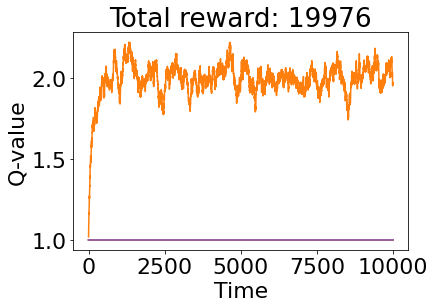

<Figure size 432x288 with 0 Axes>

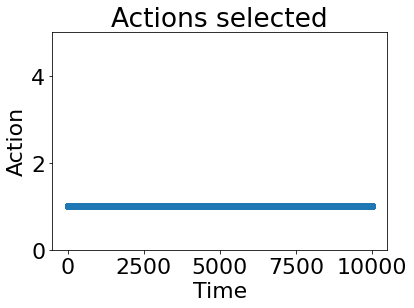

In [ ]:
## monolithic bandits

mono_epsilon = 0
mono_lr = 0.01
means = [1,2,3,4,5]
vars = [1 for i in range(len(means))]
n_bandits = len(means)
starting_q = 1
bandits = [bandit(means[i],vars[i]) for i in range(n_bandits)]
mono_agent = agent(n_bandits,mono_epsilon,mono_lr,starting_q = starting_q)
trials = 10000
trial_swap = 20000

for i in range(trials):
  if i+1 % trial_swap == 0:
    np.random.shuffle(bandits)
  action = mono_agent.select_action()
  reward = mono_agent.pull(action,bandits)
  mono_agent.update_q_values(action,reward)
  mono_agent.epsilon -= 0.001

plt.plot(mono_agent.historical_q_values);
plt.title(f'Total reward: {int(sum(mono_agent.rewards))}')
plt.ylabel('Q-value')
plt.xlabel('Time')
plt.figure()
plt.scatter(range(trials),mono_agent.historical_actions);
plt.title('Actions selected')
plt.ylabel('Action')
plt.xlabel('Time')
plt.ylim([0,5])


Text(0.5, 0, 'Time')

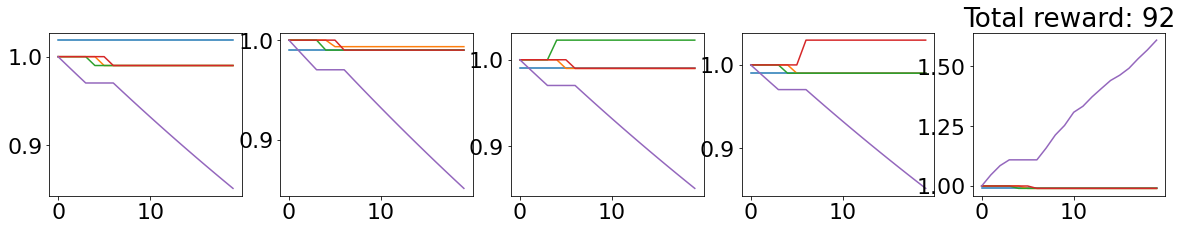

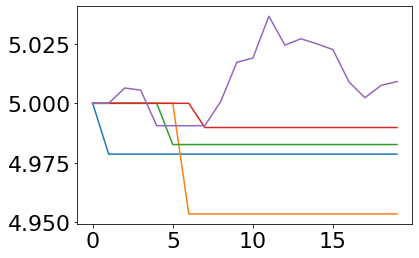

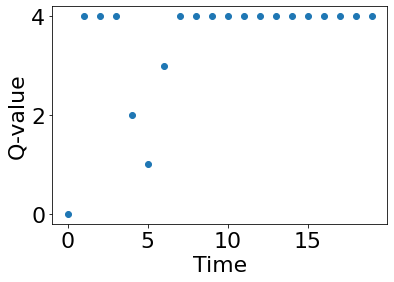

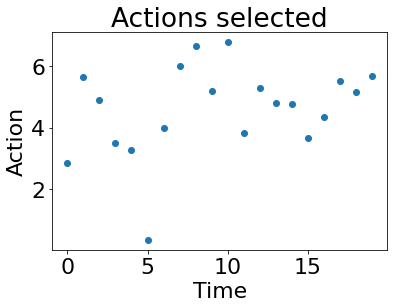

In [ ]:
## multi-agent bandits
means = [1,2,3,4,5]
trial_swap = 10000
n_bandits = len(means)
vars = [1 for i in range(len(means))]
bandits = [bandit(means[i],vars[i]) for i in range(n_bandits)]

n_agents = n_bandits
starting_q = 1
epsilon = 0
lr = 0.01
agents = [agent(n_bandits,epsilon,lr,fav_bandit = i,starting_q = starting_q) for i in range(n_agents)]

historical_actions = []
historical_rewards = []
historical_qvals = []

def select_multiagent_action(agents):
  q_values = sum([agents[i].q_values for i in range(n_agents)])
  historical_qvals.append(copy.copy(q_values))
  if np.random.uniform() > epsilon:# and not np.all(q_values == q_values[0]):  # want to choose randomly on the first step when all vals are the same
    action = np.random.choice(np.flatnonzero(q_values == q_values.max()))
    # action = np.argmax(q_values)
    historical_actions.append(copy.copy(action))
    return action
  else:
    action = np.random.randint(n_bandits)
    historical_actions.append(copy.copy(action))
    return action


trials = 20

for i in range(trials):
  if i+1 % trial_swap == 0:
    np.random.shuffle(bandits)
  action = select_multiagent_action(agents)
  reward = bandits[action].give_reward()
  historical_rewards.append(copy.copy(reward))
  reward_list = [reward*int(action == agents[i].fav_bandit) for i in range(n_agents)]
  # print(reward_list)
  for i in range(n_agents):
    agents[i].update_q_values(action,reward_list[i])
    epsilon -= 0.001


fig, axes = plt.subplots(1,n_agents,figsize = (20,3))
for i, ax in enumerate(axes.flatten()):
    ax.plot(agents[i].historical_q_values)
plt.title(f'Total reward: {int(sum(historical_rewards))}')

plt.figure()
plt.plot(historical_qvals);
plt.figure()
# plt.plot(np.cumsum(mono_agent.rewards));
plt.scatter(range(trials),historical_actions);
plt.ylabel('Q-value')
plt.xlabel('Time')

plt.figure()
plt.title('rewards')
plt.scatter(range(trials),historical_rewards);plt.title('Actions selected')
plt.ylabel('Action')
plt.xlabel('Time')

# Comparison

In [ ]:
from operator import truediv
from inspect import indentsize
## main bandits
SWAP = False
trial_swap = 2000

def run_monolithic(trials, starting_q):

  means = [1,2,3,4,5]
  n_bandits = len(means)
  vars = [1 for i in range(n_bandits)]
  mono_epsilon = 0
  mono_lr = 0.01
  bandits = [bandit(means[i],vars[i]) for i in range(n_bandits)]
  mono_agent = agent(n_bandits,mono_epsilon,mono_lr,starting_q = starting_q)

  for i in range(trials):
    if SWAP:
      if i % trial_swap == 0:
        np.random.shuffle(bandits)
    action = mono_agent.select_action()
    reward = mono_agent.pull(action,bandits)
    mono_agent.update_q_values(action,reward)
    mono_agent.epsilon -= 0.001

  return int(sum(mono_agent.rewards))

def run_modular(trials, starting_q, CEO=False):

  means = [1,2,3,4,5]
  n_bandits = len(means)
  vars = [1 for i in range(n_bandits)]
  bandits = [bandit(means[i],vars[i]) for i in range(n_bandits)]

  n_agents = n_bandits
  epsilon = 0
  lr = 0.01
  agents = [agent(n_bandits,epsilon,lr,fav_bandit = i,starting_q = starting_q) for i in range(n_agents)]
  CEO_agent = agent(n_bandits,epsilon,lr,starting_q = starting_q)

  historical_actions = []
  historical_rewards = []
  historical_qvals = []

  def select_multiagent_action(agents):
    q_values = sum([agents[i].q_values for i in range(n_agents)])
    historical_qvals.append(copy.copy(q_values))
    if np.random.uniform() > epsilon:# and not np.all(q_values == q_values[0]):  # want to choose randomly on the first step when all vals are the same
      action = np.random.choice(np.flatnonzero(q_values == q_values.max()))
      # action = np.argmax(q_values)
      historical_actions.append(copy.copy(action))
      return action
    else:
      action = np.random.randint(n_bandits)
      historical_actions.append(copy.copy(action))
      return action


  for i in range(trials):
    if SWAP:
      if i % trial_swap == 0:
        np.random.shuffle(bandits)

    if CEO:
      ceo_action = CEO_agent.select_action()
      action = agents[ceo_action].select_action()
    else:
      action = select_multiagent_action(agents)

    reward = bandits[action].give_reward()
    historical_rewards.append(copy.copy(reward))
    reward_list = [reward*int(action == agents[i].fav_bandit) for i in range(n_agents)]

    if CEO:
      CEO_agent.update_q_values(action,reward)
    # print(reward_list)
    for i in range(n_agents):
      agents[i].update_q_values(action,reward_list[i])
      epsilon -= 0.001

  return int(sum(historical_rewards))

### MAIN COMPARISON LOOP ####
repeats = 20
trials = 5000
starting_q = [0,0.3,0.5,0.7,1,1.3,1.5,1.7,2]
mono_results = np.empty((repeats,len(starting_q)))
mod_results = np.empty((repeats,len(starting_q)))
CEO_results = np.empty((repeats,len(starting_q)))

for i in range(repeats):
  for j in range(len(starting_q)):
    mono_results[i,j] = run_monolithic(trials,starting_q[j])
    mod_results[i,j] = run_modular(trials,starting_q[j])
    CEO_results[i,j] = run_modular(trials,starting_q[j],CEO=True)



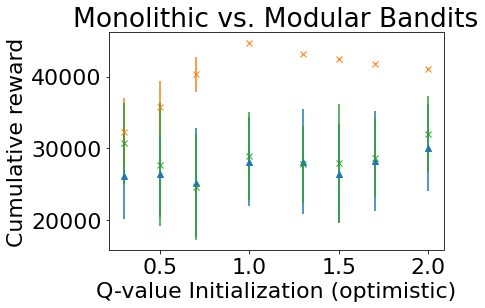

In [44]:
mono_results

y = np.mean(mono_results,0)
e = np.std(mono_results,0)
plt.errorbar(starting_q, y, e, linestyle='None', marker='^')

y = np.mean(mod_results,0)
e = np.std(mod_results,0)
plt.errorbar(starting_q, y, e, linestyle='None', marker='x')

y = np.mean(CEO_results,0)
e = np.std(CEO_results,0)
plt.errorbar(starting_q, y, e, linestyle='None', marker='x')


plt.title('Monolithic vs. Modular Bandits')
plt.ylabel('Cumulative reward')
plt.xlabel('Q-value Initialization (optimistic)')
# plt.legend(['Monolithic','Modular','CEO'])
plt.show()